In [1]:
!pip install -q tf-nightly
!pip install -q tf-models-nightly

In [2]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# from multipledispatch import dispatch 

import warnings
warnings.filterwarnings('ignore')

import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [16]:
# !cp -r data/ /content

In [17]:
df = pd.read_csv("/content/data/yelp_academic_dataset_sample005_filter.csv")
df.head(1)

,review_id,user_id,business_id,review_stars,review_text,review_text_after_cleaning,user_review_count,user_elite,user_friends,user_fans,user_average_stars,user_total_compliments,business_name,business_categories,business_stars,to_recommend,num_user_friends
0,yNB39szX3M8mTEzTtsgoCw,Y1iCYGvLf4ifPoXlKLGq-w,o2Qh4SiGYJ7BK4hP7dfkrw,5,This is an amazing indian Bistro!!I If I do sa...,amaz bistroi say myself never cuisin glad expe...,1,0,None,0,5.0,0,Saffron Indian Bistro,"Restaurants, Indian",4.5,True,0


In [18]:
hub_url_bert = "https://tfhub.dev/google/small_bert/bert_uncased_L-8_H-512_A-8/2"
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [19]:
%%time
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(X, tokenizer):
  num_examples = len(X)
  
  sentence1 = tf.ragged.constant([encode_sentence(s, tokenizer) for s in np.array(X)])

#   sentence2 = tf.ragged.constant([
#       encode_sentence(s, tokenizer)
#        for s in np.array(glue_dict["sentence2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
#   type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat([type_cls, type_s1], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

def num_word(data):
    return len(data.split(" "))
X = df["review_text_after_cleaning"].apply(lambda x : x if num_word(x) < 150 else ' '.join(x.split(" ")[:150]))
y = df["review_stars"].apply(lambda x : x-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(vocab_file=os.path.join(gs_folder_bert, "vocab.txt"), do_lower_case=True)
print("Vocab size:", len(tokenizer.vocab))

X_train = bert_encode(X_train, tokenizer)
X_test = bert_encode(X_test, tokenizer)

for key, value in X_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'X_train_labels shape: {y_train.shape}')

for key, value in X_test.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'X_train_labels shape: {y_test.shape}')

Vocab size: 30522
input_word_ids  shape: (268540, 307)
input_mask      shape: (268540, 307)
input_type_ids  shape: (268540, 307)
X_train_labels shape: (268540,)
input_word_ids  shape: (132267, 273)
input_mask      shape: (132267, 273)
input_type_ids  shape: (132267, 273)
X_train_labels shape: (132267,)
CPU times: user 6min 35s, sys: 1.29 s, total: 6min 36s
Wall time: 6min 37s


In [20]:
bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
bert_config = bert.configs.BertConfig.from_dict(config_dict)
config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [24]:
config_dict = {"hidden_size": 384, "hidden_act": "relu", "initializer_range": 0.02, "vocab_size": 30522, "hidden_dropout_prob": 0.1, "num_attention_heads": 4, 
               "type_vocab_size": 2, "max_position_embeddings": 312, "num_hidden_layers": 4, "intermediate_size": 1024, "attention_probs_dropout_prob": 0.2}
bert_config = bert.configs.BertConfig.from_dict(config_dict)

In [22]:
# Set up epochs and steps
epochs = 3
batch_size = 128
eval_batch_size = 32

train_data_size = len(y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [25]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config, num_labels=5)
# bert_classifier.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError('rmse'), 'mae'])
# bert_classifier.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs)

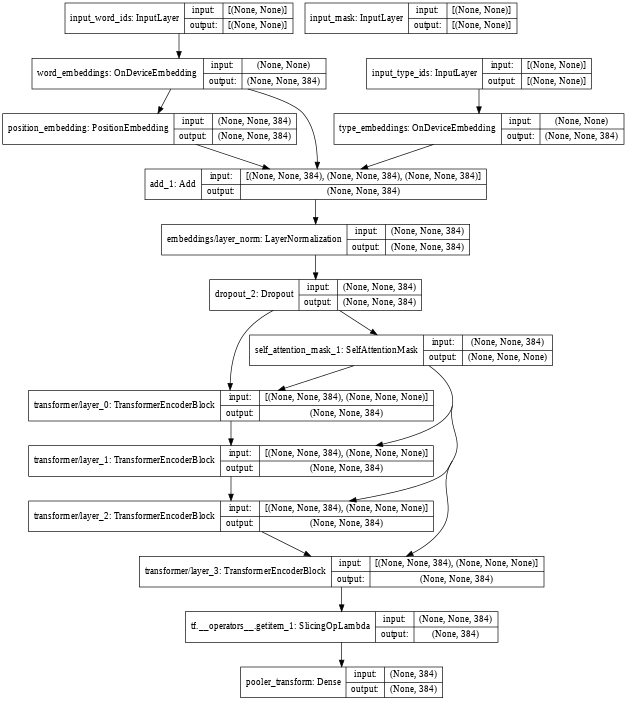

In [26]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

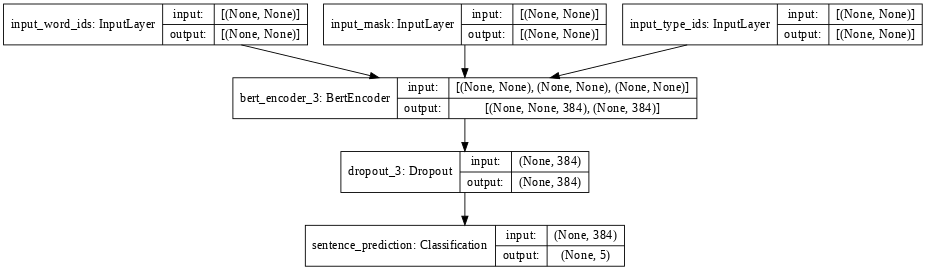

In [28]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=64)